# Transfer Learning

In [1]:
# libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# data
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-08-03 14:29:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.24, 13.226.50.63, 13.226.50.98, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  48.0MB/s    in 0.9s    

2021-08-03 14:29:46 (48.0 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [5]:
mean = np.array([0.536, 0.321, 0.562])
std = np.array([0.243,0.283, 0.233])

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)                       
    ]),
}

In [10]:
# import data
data_dir = 'hymenoptera_data'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle = True, num_workers = 0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes 
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7ff52ef22550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ff52ef22410>}


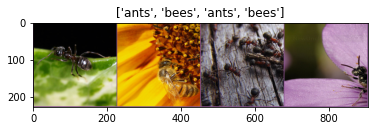

In [9]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range (num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train': 
        model.train() # set model to training mode
      else:
        model.eval() # set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # stats
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) 

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss:{epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      #deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
  print(f'Best val Acc: {best_acc:4.f}')

  # load best models weights
  model.load_state_dict(best_model_wts)
  return model

In [15]:
# 1 option
model = models.resnet18(pretrained = True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#for epoch in range(100):
#  train() # optimizer.step()
#  evaluate()
# scheduler.step()

#model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
# 2 option
model = models.resnet18(pretrained = True)
for param in model.parameters():
  param.requires_gra = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#for epoch in range(100):
#  train() # optimizer.step()
#  evaluate()
#  scheduler.step()

model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)